In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import gc
from sklearn.metrics import roc_auc_score

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language, rolling_mean

from src.attention_saver import Mistral7BAttentionSaver
from src.influence.influence import Influence, AttentionRollout

import scienceplots
plt.style.use(['science','no-latex'])

tqdm.pandas()

## Loading dataset

In [3]:
notebook_login()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

df = load_dataset("stas/openwebtext-10k", cache_dir= "/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Obtaining generation results

In [6]:
base_instruction = "Summarize in french"
df["context_length"] = (base_instruction + " \n" + df["text"])\
    .progress_apply(get_context_length, tokenizer = tokenizer)

100%|██████████| 10000/10000 [00:18<00:00, 533.45it/s]


In [7]:
base_path = "data/complete_study_200_tokens/checkpoints/"
all_results = []
for delta_attention in [0., 0.5 ,1., 2.0, 5.0]:
    for all_layers in ["all", "none"]:
        path = os.path.join(
            base_path,
            f"{all_layers}_layers_generated_delta={delta_attention}.pkl"
        )
        try:
            results_df = pd.read_pickle(path).T

        except Exception as e:
            print(e)
            continue

        parsed_results_dict = dict()

        for epoch in range(len(results_df.columns)-1):
            for (idx, result_epoch) in results_df.loc[:,f"epoch {epoch}"].items():
                s = pd.Series(result_epoch)\
                    .apply(get_generated_text)\

                data = pd.DataFrame(s).T
                data.index = [idx]

                if not epoch in parsed_results_dict:
                    parsed_results_dict[epoch] = []

                parsed_results_dict[epoch].append(data)

            parsed_results_dict[epoch] = pd.concat(parsed_results_dict[epoch])

        all_dfs = []

        for epoch in parsed_results_dict.keys():
            temp_df = pd.melt(
                parsed_results_dict[epoch].reset_index(),
                var_name = "instruction",
                value_name = "generated_text",
                id_vars = "index",
            )

            temp_df["is_french"] = temp_df["generated_text"].apply(is_text_in_language)

            temp_df["generation_epoch"] = epoch

            all_dfs.append(temp_df)

        melted_df = pd.concat(all_dfs)

        melted_df = pd.merge(
            melted_df,
            df[["context_length", "text"]],
            left_on="index",
            right_index=True
        )

        melted_df["context_length_bins"] = pd.cut(
            melted_df["context_length"], 
            np.arange(0,6_500,500)
        )

        melted_df.dropna(inplace=True)

        study_name = f"$\Delta$={delta_attention}, all_layers={all_layers}"
        
        if all_layers == 'first':
            study_name= f"$\Delta$={delta_attention}, first layer only"

        elif  all_layers == 'all':

            study_name = f"$\Delta$={delta_attention}, all_layers"
        melted_df["study"] = study_name
        
        if delta_attention ==0:
            melted_df["study"] = f"Raw model"

        all_results.append(melted_df)

[Errno 2] No such file or directory: 'data/complete_study_200_tokens/checkpoints/all_layers_generated_delta=0.0.pkl'
Exception raised while analysing the text  21 =85 9/5=4 1 2 2 0 0 0 0 2 2 1 2 2 0 0 4 9 9 9 0 0 0 0 4 9 9 9 0 0 0 0 4 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 3 9 9 9 0 0 0 0 4 9 9 9 0 0 0 0
Exception raised while analysing the text  1
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 7
Exception raised while analysing the text  1
2
3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 7
Exception raised while analysing the text  ᖺᖷ የስትስት ስትስት የንሕትንም የርንንም ስትስትስት የስትስት ስትስት የስትስት ስትስት የንንም የንሕንስትንም የስትስት የንስትንም የንንም የስትስት የንስትንም የንስትንም የን

## Influence vs probability output in french


In [8]:
probability_in_french = pd.concat(all_results)\
    .query("study == 'Raw model'")\
    .groupby(['index'])\
    .is_french\
    .mean()\
    .reset_index()

In [9]:
unique_text_df = pd.concat(all_results)\
    .groupby(['instruction', 'index'])\
    [['text', "context_length"]]\
    .first()\
    .reset_index()\
    .query(" context_length < 4100")

In [13]:
N_LAYERS = 32
influence = Influence()
results_raw = influence(
    base_model,
    tokenizer,
    unique_text_df.sort_values("context_length", ascending = False),
    0,
    N_LAYERS,
    augmented_layers="none",
    use_values=False,
    instruction_in_text=False
)

Forward propagation on instruction = You must summarize the following text in french: . Index = 117
Finished forward step in 2.045546293258667 s


 75%|███████▌  | 24/32 [00:10<00:03,  2.28it/s]

In [12]:
results_dict = dict()
for key in results_raw:
    results_dict[key] = {}

    for layer in [0, 15, 31]:
        results_dict[key][layer] = results_raw[key]\
            ['influences'][layer][-10:]\
            .mean()\
            .item()

In [18]:
influence_df = pd.Series(results_dict)\
    .reset_index()\
    .rename(
        columns = {"level_0": "index", "level_1": "instruction", 0:"influence"}
    )

In [14]:
influence_df.to_pickle("data/influences/influences_all_phrases.pkl")

In [10]:
influence_df = pd.read_pickle("data/influences/influences_all_phrases_all_layers.pkl")

In [11]:
influence_df['layer_31'] = influence_df['influence'].apply(lambda x: x[31])
influence_df['layer_0'] = influence_df['influence'].apply(lambda x: x[0])

## Computing AUC Score

In [12]:
grouped_text = pd.concat(all_results)\
    .query("study == 'Raw model' & context_length < 4100")\
    [['is_french', "instruction", "index", "context_length"]]

In [13]:
probability_df = pd.merge(
    grouped_text,
    influence_df,
    on = ['instruction', 'index']
)

In [14]:
probability_df['context_length_bins'] = pd.cut(
    probability_df['context_length'],
    range(0,5_000, 2000)
)

In [19]:
targets, probas = probability_df['is_french'].astype(int), probability_df['layer_31']
targets, probas_first = probability_df['is_french'].astype(int), probability_df['layer_0']


In [20]:
probability_df

,is_french,instruction,index,context_length,influence,layer_31,layer_0,context_length_bins
0,False,Summarize in french:,656,4085,"{0: 2.3186206817626953e-05, 1: 5.8352947235107...",0.011185,0.000023,NaN
1,False,Summarize in french:,1879,4046,"{0: 2.2590160369873047e-05, 1: 5.6982040405273...",0.010002,0.000023,NaN
2,False,Summarize in french:,1617,4040,"{0: 2.104043960571289e-05, 1: 5.42402267456054...",0.009613,0.000021,NaN
3,False,Summarize in french:,8016,4012,"{0: 2.2172927856445312e-05, 1: 5.3167343139648...",0.010490,0.000022,NaN
4,False,Summarize in french:,1125,4012,"{0: 2.4080276489257812e-05, 1: 5.8412551879882...",0.009575,0.000024,NaN
...,...,...,...,...,...,...,...,...
3481,True,You must summarize the following text in french:,7394,256,"{0: 0.00042557716369628906, 1: 0.0006756782531...",0.046082,0.000426,"(0.0, 2000.0]"
3482,True,You must summarize the following text in french:,6932,243,"{0: 0.0005002021789550781, 1: 0.00080728530883...",0.041199,0.000500,"(0.0, 2000.0]"
3483,True,You must summarize the following text in french:,3943,235,"{0: 0.00046372413635253906, 1: 0.0007410049438...",0.044861,0.000464,"(0.0, 2000.0]"
3484,True,You must summarize the following text in french:,4922,224,"{0: 0.0005373954772949219, 1: 0.00077104568481...",0.041687,0.000537,"(0.0, 2000.0]"


In [21]:
roc_auc_score(targets, probas)

0.7541265589082369

In [22]:
roc_auc_score(targets, probas_first)

0.7493260752770469

## AUC of context length

In [23]:
features_length = probability_df['context_length']

In [24]:
roc_auc_score(targets, 1/features_length)

0.785574024402921

## Attention rollout

In [25]:
unique_text_df = pd.concat(all_results)\
    .groupby(['instruction', 'index'])\
    [['text', "context_length"]]\
    .first()\
    .reset_index()\
    .query(" context_length < 4100")

In [26]:
unique_text_df

,instruction,index,text,context_length
0,Important: Summarize in french:,35,"Okay, are y’all ready for the longest sex ques...",3819
4,Important: Summarize in french:,247,Large lake in the Northwest Territories of Can...,2654
10,Important: Summarize in french:,408,"Tweet\n\nProfessor Joan Goodman, the director ...",2772
13,Important: Summarize in french:,590,Secret Empire Tie-ins (ongoing series)\n\nIn t...,3894
14,Important: Summarize in french:,592,An 'immigrant hating' Frenchman who planned 15...,2356
...,...,...,...,...
713,You must summarize the following text in french:,9683,With the loss of the Agena target vehicle shor...,2562
715,You must summarize the following text in french:,9692,Roughly half of voters in Toronto — a traditio...,1982
717,You must summarize the following text in french:,9842,"“We are taking the heat from both sides,” Geha...",1945
718,You must summarize the following text in french:,9965,Ladder racks are extremely useful tools. They ...,772


In [27]:
influence = Influence()
N_LAYERS = 32

influence_rollout = influence(
    base_model,
    tokenizer,
    unique_text_df.sort_values("context_length", ascending = False),
    0,
    N_LAYERS,
    augmented_layers="none",
    use_values=False,
    instruction_in_text=False,
)


TypeError: BaseMetric.__init__() missing 3 required positional arguments: 'base_model', 'tokenizer', and 'num_layers'

In [25]:
influence_rollout

NameError: name 'influence_rollout' is not defined

In [12]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
results_dict = dict()
last_layer_influences = dict()
first_layer_influences = dict()

for key in influence_rollout:
    results_dict[key] = {}

    for layer in range(32):
        results_dict[key][layer] = influence_rollout[key]\
            [layer][-10:]\
            .mean()\
            .item()
        
        last_layer_influences[key] = influence_rollout[key]\
            [31]
        
        first_layer_influences[key] = influence_rollout[key]\
            [0]

In [23]:
pd.Series(results_dict)

6936  Summarize in french:     {0: 0.000614240940194577, 1: 0.000614286225754...
1223  Summarize in french:     {0: 0.0003732677432708442, 1: 0.00037329518818...
5815  Summarize in french:     {0: 0.0020491413306444883, 1: 0.00204923772253...
dtype: object

In [57]:
pd.Series(last_layer_influences).to_pickle("data/influences/last_layer_influences.pkl")

pd.Series(first_layer_influences).to_pickle("data/influences/first_layer_influences.pkl")

In [19]:
pd.DataFrame(results_dict).T\
    .to_pickle("data/influences/non_normalized_influence_all_layers.pkl")

In [28]:
influence_df = pd.read_pickle("data/influences/non_normalized_influence_all_layers.pkl")\
    .reset_index()\
    .rename(
        columns = {"level_0": "index", "level_1": "instruction", 31:"rollout"}
    )

In [29]:
probability_df = pd.merge(
    grouped_text,
    influence_df,
    on = ['instruction', 'index']
)

In [31]:
row = df.query("context_length > 3500 & context_length < 4000").sample(1, random_state = 42)
row['instruction'] = "Summarize in French"

rollout_calculator = AttentionRollout(
    base_model,
    tokenizer,
    32
)

rollout = rollout_calculator(
    row.reset_index(),
    delta_attention= 0,
    instruction_in_text= False,
)

5 10
Forward propagation on instruction = Summarize in French. Index = 0
Influence tokens : 5 to 10
Studying influence to 'Summarize in French'
Finished forward step in 7.354038238525391 s


100%|██████████| 32/32 [00:00<00:00, 90.69it/s]


Passing tensors to CPU...


In [32]:
influence_calculator = Influence(
    base_model,
    tokenizer,
    32
)

influence = influence_calculator(
    row.reset_index(),
    delta_attention= 0,
    instruction_in_text= False,
)

5 10
Forward propagation on instruction = Summarize in French. Index = 0
Influence tokens : 5 to 10
Studying influence to 'Summarize in French'
Finished forward step in 7.315856695175171 s


100%|██████████| 32/32 [00:00<00:00, 86.41it/s]


Passing tensors to CPU...


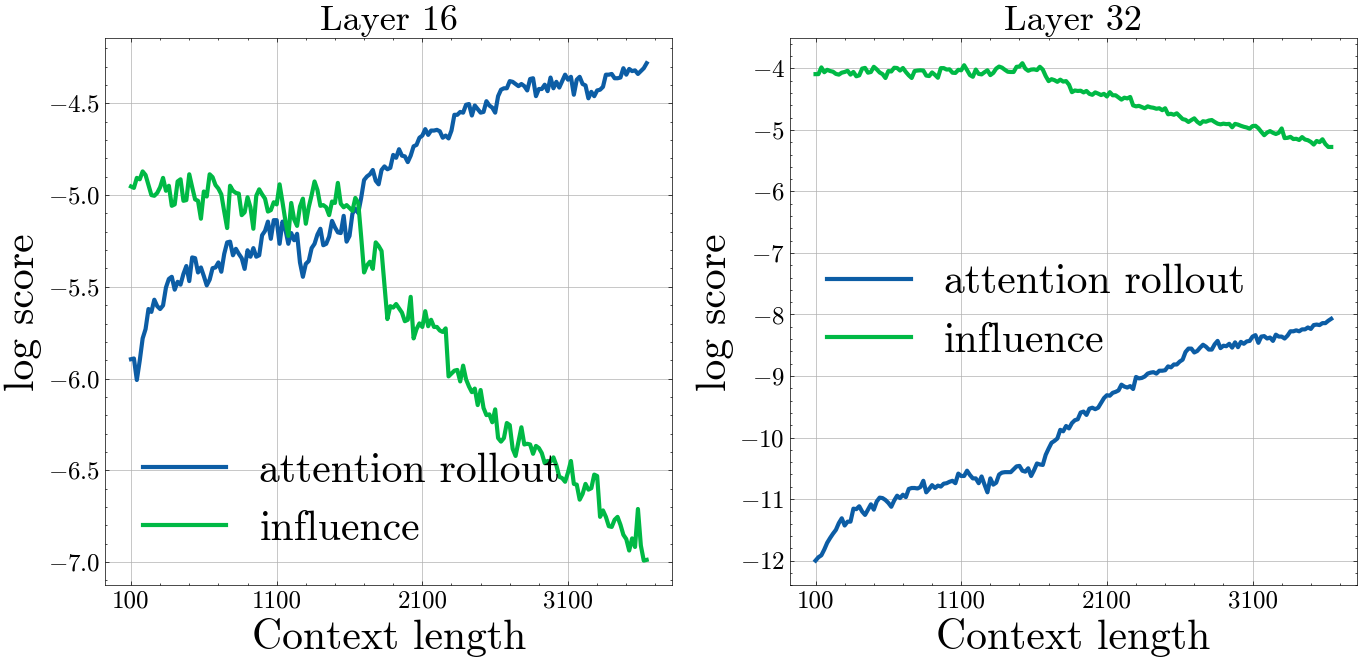

In [36]:
plt.rc("font", size =16)
key = list(rollout.keys())[0]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))


for id, ((text_id, instruction), values) in enumerate(rollout.items()):
    influences = values['influences']
    # axes[0].plot(
    #     torch.log(rolling_mean(influences[0], 20)[5:]),
    #     label = "attention rollout",
    #     linewidth = 2
    # )


    axes[0].plot(
        torch.log(rolling_mean(influences[15], 20)[5:]),
        label = "attention rollout",
        linewidth = 3
    )


    axes[1].plot(
        torch.log(rolling_mean(influences[31], 20)[5:]),
        label = "attention rollout",
        linewidth = 3
    )

for id, ((text_id, instruction), values) in enumerate(influence.items()):
    influences = values['influences']
    # axes[0].plot(
    #     torch.log(rolling_mean(influences[0], 20)[5:]),
    #     label = "influence",
    #     linewidth = 2
    # )


    axes[0].plot(
        torch.log(rolling_mean(influences[15], 20)[5:]),
        label = "influence",
        linewidth = 3
    )


    axes[1].plot(
        torch.log(rolling_mean(influences[31], 20)[5:]),
        label = "influence",
        linewidth = 3
    )
label_fontsize = 30
legend_fontsize = 30
tick_fontsize = 18
title_fontsize = 26

axes[0].legend(prop= {"size" : legend_fontsize})
axes[1].legend(prop= {"size" : legend_fontsize})
# axes[2].legend()

axes[0].set_title("Layer 16", fontsize = title_fontsize)
axes[1].set_title("Layer 32", fontsize =  title_fontsize)
# axes[2].set_title("Layer 32")

axes[0].grid(True)
axes[1].grid(True)
# axes[2].grid(True)


axes[0].set_xlabel("Context length", fontsize =  label_fontsize)
axes[0].set_ylabel("log score", fontsize =  label_fontsize )

axes[1].set_xlabel("Context length", fontsize =  label_fontsize )
axes[1].set_ylabel("log score", fontsize =  label_fontsize )

# axes[2].set_xlabel("context length" )
# axes[2].set_ylabel("log influence" )

xticks = axes[0].get_xticks()
new_xticks = xticks * 20 + 100

# Set the new x-tick labels
axes[0].set_xticklabels(new_xticks.astype(int))
axes[1].set_xticklabels(new_xticks.astype(int))
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
# axes[2].set_xticklabels(new_xticks.astype(int))

plt.tight_layout()
plt.savefig("img/influence vs attention rollout.pdf")

In [38]:
probability_df['context_length_bins'] = pd.cut(
    probability_df['context_length'],
    range(0,5_000, 2000)
)
def get_auc_per_context_len(x, column : str):
    return roc_auc_score(x['is_french'].astype(int), x[column])

auc_rollout = probability_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = "rollout")\
    .reset_index()

auc_rollout['metric'] = 'rollout'


In [40]:
targets, probas = probability_df['is_french'].astype(int), probability_df['rollout']

In [41]:
probability_df['is_french'].corr(probability_df['rollout'])

-0.3583169100981586

In [42]:
roc_auc_score(targets, probas)

0.23458989077591924

In [17]:
merged_df = pd.merge(
    influence_df,
    probability_in_french,
    on= ['index'],
    how = 'inner'
)

In [18]:
merged_df['influence'] = merged_df['influence'].apply(lambda x: x[31])

In [19]:
merged_df = merged_df.groupby("index")\
    [["is_french", "influence"]]\
    .mean()

In [20]:
correlation = merged_df['influence'].corr(merged_df['is_french'])
correlation

0.7155391117949951

In [21]:
merged_df['is_french'] = merged_df.is_french.astype(float)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1600x600 with 0 Axes>

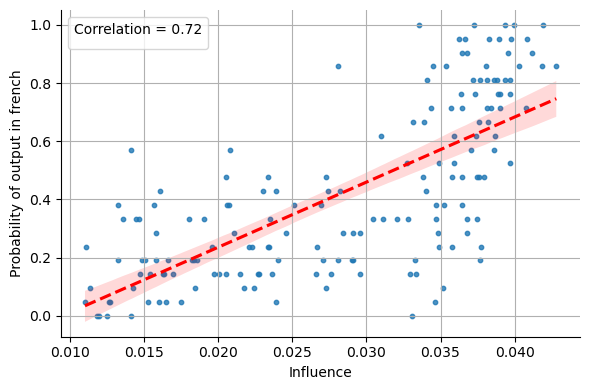

In [23]:
# plt.scatter(
#     merged_df['influence'], 
#     merged_df['is_french'],
#     marker = '.',
#     label = f"Correlation = {round(correlation, 2)}"
# )

plt.figure(figsize=(16,6))

sns.lmplot(
    merged_df,
    x = 'influence',
    y = 'is_french',
    height=4,
    aspect=1.5,
    scatter_kws={'s': 10, 'label': "Hello"},
    line_kws={'color': 'red', "linestyle": "dashed"},
    facet_kws={"legend_out": False},
    legend=True
)

plt.xlabel("Influence")
plt.ylabel("Probability of output in french")
plt.legend(title = f"Correlation = {round(correlation, 2)}")
# plt.title(rf"Setup : $\Delta = 0$")
plt.grid()